In [1]:
import os

import getGaiaDR2 as gaia
import gnomonic as gn

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as c
import astropy.table as tb
import astropy.coordinates as co
from astropy.time import Time
from scipy.spatial.ckdtree import cKDTree
from sklearn.model_selection import train_test_split

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
"""Choose an exposure that is definitely in zone 134."""
zoneDir = "/data3/garyb/tno/y6/zone134"
tile0 = "DES2203-4623_final.fits"
file0 = os.path.join(zoneDir, tile0)
tab0 = tb.Table.read(file0)
expNum = np.unique(tab0["EXPNUM"])[10]

In [3]:
"""
Find the approximate patch of sky (denoted by the center of the patch and
the width and height (except all DES exposures are the same size, so only the
center coordinate needs to be known)) in order to retrieve stars from the Gaia
catalog.
"""
pos_tab = tb.Table.read("../y6a1.exposures.positions.fits.gz", hdu=1)
pos_tab = pos_tab[pos_tab["expnum"] == expNum]
ra0 = pos_tab["ra"][0]
dec0 = pos_tab["dec"][0]

In [4]:
"""Find all tiles that our exposure is a part of."""
tiles_tab = tb.Table.read("../expnum_tile.fits.gz")
tiles = tiles_tab[tiles_tab["EXPNUM"] == expNum]["TILENAME"]

DES_tab = tab0.copy()
DES_tab.remove_rows(np.arange(len(DES_tab)))
for tile in tiles:
    try:
        tile = str(tile) + "_final.fits"
        file = os.path.join(zoneDir, tile)
        tab = tb.Table.read(file)
        tab = tab[tab["EXPNUM"] == expNum]
        DES_tab = tb.vstack([DES_tab, tab])
    except FileNotFoundError:
        print(f"File not found: {file}, continuing without it")
        continue
print(f"Exposure: {expNum}")
print(f"Band: {np.unique(DES_tab['BAND'])[0]}")
print(f"Number of objects: {len(DES_tab)}")

DES_obs = Time(pos_tab["mjd_mid"][0], format="mjd", scale="tcb")
DES_ra = np.array(DES_tab["NEW_RA"])*u.deg
DES_dec = np.array(DES_tab["NEW_DEC"])*u.deg
DES_err = np.array(DES_tab["ERRAWIN_WORLD"])*u.deg

Exposure: 364215
Band: z
Number of objects: 110646


In [5]:
"""Retrieve Gaia data."""
GAIA_tab = gaia.getGaiaCat(ra0, dec0, 2.5, 2.5)

GAIA_obs = Time("J2015.5", format="jyear_str", scale="tcb")
GAIA_ra = np.array(GAIA_tab["ra"])*u.deg - 360*u.deg
GAIA_dec = np.array(GAIA_tab["dec"])*u.deg
GAIA_pmra_cosdec = np.array(GAIA_tab["pmra"])*u.mas/u.yr
GAIA_pmdec = np.array(GAIA_tab["pmdec"])*u.mas/u.yr
# Need to figure out how to handle Gaia's negative parallax problem
# GAIA_parallax = co.Distance(parallax=np.array(GAIA_tab["parallax"])*u.mas)

INFO: Query finished. [astroquery.utils.tap.core]


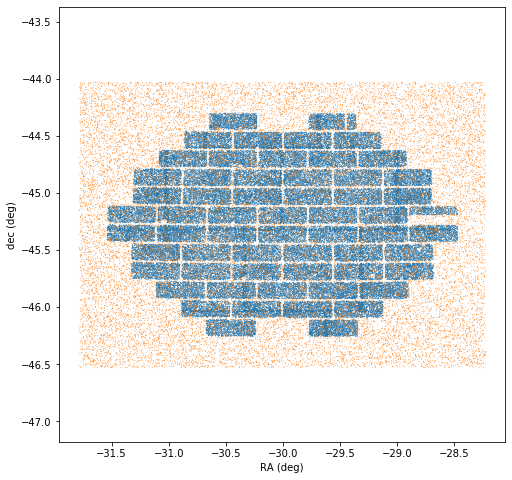

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(
    DES_ra, DES_dec,
    marker=".", s=0.1)
plt.scatter(
    GAIA_ra, GAIA_dec,
    marker=".", s=0.1)
plt.xlabel("RA (deg)")
plt.ylabel("dec (deg)")
plt.axis("equal")
plt.show()

In [7]:
"""Remap Gaia to the moment of DES exposure."""
dt = DES_obs - GAIA_obs
GAIA_ra += dt * GAIA_pmra_cosdec / np.cos(GAIA_dec)
GAIA_dec += dt * GAIA_pmdec

In [9]:
"""Match DES objects with Gaia counterparts based on how close together they are on the sky."""
X_DES = co.SkyCoord(DES_ra, DES_dec)
X_GAIA = co.SkyCoord(GAIA_ra, GAIA_dec)

idx, sep2d, dist3d = co.match_coordinates_sky(X_GAIA, X_DES)
tol = 0.5*u.arcsec
ind_GAIA = np.where(sep2d < tol)[0]
ind_DES = idx[ind_GAIA]

X_GAIA = X_GAIA[ind_GAIA]

print(f"There were {ind_GAIA.size} matches within {tol}.")

There were 10847 matches within 0.5 arcsec.


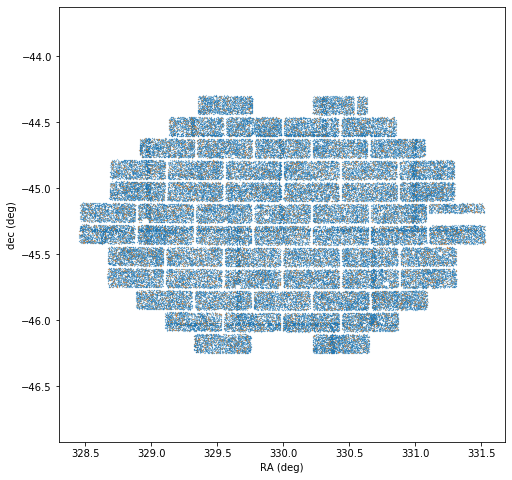

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(
    X_DES.ra, X_DES.dec,
    marker=".", s=0.1)
plt.scatter(
    X_GAIA.ra, X_GAIA.dec,
    marker=".", s=0.1)
plt.xlabel("RA (deg)")
plt.ylabel("dec (deg)")
plt.axis("equal")
plt.show()

In [15]:
"""Gnomonic projection for DES and GAIA stars."""
def gnomonicProjection(X, RA0=ra0, dec0=dec0, rot=0):
    pole = co.SkyCoord(RA0, dec0, unit='deg', frame='icrs')
    frame = pole.skyoffset_frame(rotation=co.Angle(rot, unit='deg'))

    s = X.transform_to(frame)

    # Get 3 components on unit sphere
    x = np.cos(s.lat.radian)*np.cos(s.lon.radian)
    y = np.cos(s.lat.radian)*np.sin(s.lon.radian)
    z = np.sin(s.lat.radian)
    out_x = y/x * (180. / np.pi)
    out_y = z/x * (180. / np.pi)
    return np.array([out_x, out_y])

X_gn_DES = gnomonicProjection(X_DES)
X_gn_GAIA = gnomonicProjection(X_GAIA)

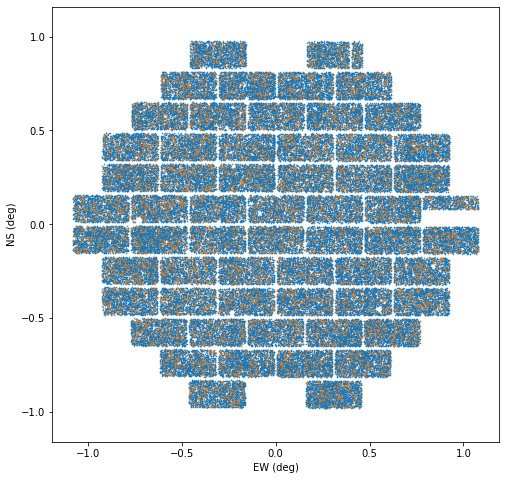

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(
    *X_gn_DES,
    marker=".", s=1)
plt.scatter(
    *X_gn_GAIA,
    marker=".", s=1)
plt.xlabel("EW (deg)")
plt.ylabel("NS (deg)")
plt.axis("equal")
plt.show()

In [17]:
X_tv = X_gn_DES.T[ind_DES]
Y_tv = X_gn_GAIA.T

train_test_split

In [31]:
X_pred = np.delete(X_gn_DES, ind_DES, axis=1).shape

(2, 33005)

In [32]:
tab_DES.info

<Table length=33005>
       name        dtype 
----------------- -------
               RA float64
              DEC float64
    ERRAWIN_WORLD float64
       XWIN_IMAGE float64
       YWIN_IMAGE float64
        FLUX_AUTO float64
     FLUXERR_AUTO float64
     IMAFLAGS_ISO   int32
           EXPNUM   int64
           CCDNUM   int16
             BAND  bytes5
          MJD_OBS float64
         MAG_ZERO float64
          VERSION  bytes5
           X_GNOM float64
           Y_GNOM float64
       MAG_AUTO_G float64
       MAG_AUTO_R float64
       MAG_AUTO_I float64
       MAG_AUTO_Z float64
       MAG_AUTO_Y float64
  COADD_OBJECT_ID   int64
      FLUX_AUTO_G float64
      FLUX_AUTO_R float64
      FLUX_AUTO_I float64
      FLUX_AUTO_Z float64
      FLUX_AUTO_Y float64
    MAGERR_AUTO_G float64
    MAGERR_AUTO_R float64
    MAGERR_AUTO_I float64
    MAGERR_AUTO_Z float64
    MAGERR_AUTO_Y float64
   FLUXERR_AUTO_G float64
   FLUXERR_AUTO_R float64
   FLUXERR_AUTO_I float64
   FLUXERR_AUTO_Z

In [33]:
tab_DES["ERRAWIN_WORLD"]

5.060100011178292e-05
5.127939743942989e-07
1.91134995475295e-06
3.0222199711715803e-05
1.3359100194065832e-05
2.0627299818443134e-05
3.084150012000464e-05
4.4163898564875126e-05
1.89457005035365e-05
2.7203899662708864e-05
3.704470145748928e-05


In [35]:
tab_GAIA.info

<Table masked=True length=33218>
   name     dtype  shape   unit                              description                             n_bad
---------- ------- ----- -------- ------------------------------------------------------------------ -----
 source_id   int64                Unique source identifier (unique within a particular Data Release)     0
        ra float64            deg                                                    Right ascension     0
       dec float64            deg                                                        Declination     0
  parallax float64            mas                                                           Parallax     0
      pmra float64       mas / yr                         Proper motion in right ascension direction     0
     pmdec float64       mas / yr                             Proper motion in declination direction     0
      gmag float32            mag                                              G-band mean magnitude     0
    

In [52]:
tab_GAIA["error"]

2.0955351724409007e-08
3.7367329251764975e-07
1.0207599936995199e-07
3.763922708454299e-08
1.2639138649865267e-07
7.527060683205067e-08
1.0592234995192282e-07
3.537616501097214e-08
3.3287769776305685e-08
5.195252245830017e-08
5.584259840231279e-08


In [50]:
np.reshape(tab_GAIA["cov"][0].data, (5, 5))

array([[ 4.3993131e-03,  2.4268595e-03,  8.8224851e-04, -1.6275787e-03,
         3.1253777e-04],
       [ 2.4268595e-03,  7.1489080e-03,  2.1192796e-05, -8.4519498e-03,
        -3.5104417e-04],
       [ 8.8224851e-04,  2.1192796e-05,  2.4587322e-02,  8.8948216e-03,
        -4.2681922e-03],
       [-1.6275787e-03, -8.4519498e-03,  8.8948216e-03,  4.0560946e-02,
        -3.4151524e-03],
       [ 3.1253777e-04, -3.5104417e-04, -4.2681922e-03, -3.4151524e-03,
         1.4427730e-02]], dtype=float32)